In [1]:
import os
if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import bayesflow as bf
from scipy import constants
from scipy.integrate import solve_ivp

G = constants.G

INFO:bayesflow:Using backend 'jax'


#### Simulation

In [3]:
RNG = np.random.default_rng(42)

In [4]:
# Fixed constants and initial setup
masses = np.array([100, 100, 100])  # Equal masses for the 3 bodies


def compute_velocity_sigma(positions, masses, G=G, alpha=0.5):
    """
    Compute the velocity dispersion (sigma) for a set of bodies
    based on their average separation and escape velocity.

    Parameters:
    - positions: (3,3) array of x,y,z positions
    - masses: array of body masses
    - G: gravitational constant
    - alpha: fraction of escape velocity used for sigma

    Returns:
    - sigma: velocity dispersion
    """
    # Pairwise distances between the three bodies
    r12 = np.linalg.norm(positions[0] - positions[1])
    r13 = np.linalg.norm(positions[0] - positions[2])
    r23 = np.linalg.norm(positions[1] - positions[2])

    # Average separation
    r_avg = (r12 + r13 + r23) / 3.0

    # Escape velocity for the system
    total_mass = np.sum(masses)
    v_escape = np.sqrt(2 * G * total_mass / r_avg)

    # Scaled velocity dispersion
    sigma = alpha * v_escape
    return sigma


def adjust_to_com_frame(positions, velocities, masses):
    """
    Shift positions and velocities into the center-of-mass frame.
    Ensures the system’s net momentum and position are zero.
    """
    total_mass = np.sum(masses)

    # Center of mass position and velocity
    com_position = np.sum(masses[:, None] * positions, axis=0) / total_mass
    com_velocity = np.sum(masses[:, None] * velocities, axis=0) / total_mass

    # Subtract COM values from all bodies
    positions_com = positions - com_position
    velocities_com = velocities - com_velocity

    return positions_com, velocities_com


def prior():
    """
    Generate random initial positions and velocities for the 3-body system.
    Positions are uniform in [-4, 4] cube.
    Velocities are Gaussian with predefined std per body.
    Adjusted to the COM frame before returning.
    """
    # Random positions (uniform cube)
    x1, x2, x3, y1, y2, y3, z1, z2, z3 = RNG.uniform(-4, 4, size=9)
    positions = np.array([
        [x1, y1, z1],
        [x2, y2, z2],
        [x3, y3, z3]
    ])

    # Predefined velocity std dev for each body
    velocity_std = [1.0, 1.0, 0.1]
    velocities = np.stack([
        RNG.normal(0, velocity_std[0], size=3),
        RNG.normal(0, velocity_std[1], size=3),
        RNG.normal(0, velocity_std[2], size=3)
    ])

    masses = np.array([100, 100, 100])

    # Shift to COM frame
    positions_com, velocities_com = adjust_to_com_frame(positions, velocities, masses)

    # Flatten to return in dictionary format
    (x1, y1, z1), (x2, y2, z2), (x3, y3, z3) = positions_com
    (vx1, vy1, vz1), (vx2, vy2, vz2), (vx3, vy3, vz3) = velocities_com

    return {
        "x1": x1, "y1": y1, "z1": z1,
        "x2": x2, "y2": y2, "z2": z2,
        "x3": x3, "y3": y3, "z3": z3,
        "vx1": vx1, "vy1": vy1, "vz1": vz1,
        "vx2": vx2, "vy2": vy2, "vz2": vz2,
        "vx3": vx3, "vy3": vy3, "vz3": vz3
    }


def derivatives(t, y):
    """
    Compute time derivatives for the 3-body problem.
    y contains positions and velocities in the form:
    [x1, y1, z1, vx1, vy1, vz1, ..., x3, y3, z3, vx3, vy3, vz3]
    """
    m1, m2, m3 = 100, 100, 100

    # Unpack positions and velocities
    x1, y1, z1, vx1, vy1, vz1 = y[0:6]
    x2, y2, z2, vx2, vy2, vz2 = y[6:12]
    x3, y3, z3, vx3, vy3, vz3 = y[12:18]

    # Position vectors
    r1 = np.array([x1, y1, z1])
    r2 = np.array([x2, y2, z2])
    r3 = np.array([x3, y3, z3])

    # Distances between bodies
    r12 = np.linalg.norm(r2 - r1)
    r13 = np.linalg.norm(r3 - r1)
    r23 = np.linalg.norm(r3 - r2)

    # Accelerations due to gravity
    a1 = G * m2 * (r2 - r1) / r12**3 + G * m3 * (r3 - r1) / r13**3
    a2 = G * m1 * (r1 - r2) / r12**3 + G * m3 * (r3 - r2) / r23**3
    a3 = G * m1 * (r1 - r3) / r13**3 + G * m2 * (r2 - r3) / r23**3

    # Concatenate velocity derivatives and acceleration derivatives
    return np.array([
        vx1, vy1, vz1, *a1,
        vx2, vy2, vz2, *a2,
        vx3, vy3, vz3, *a3
    ])


def add_noise_to_trajectories(trjs):
    """
    Add Gaussian noise to the trajectory data.
    """
    noise = RNG.normal(0, 1, size=trjs.shape)
    return trjs + noise


def remove_initial_points(trjs, t_eval):
    """
    Remove initial portion of trajectory data (e.g., first 3 units of time)
    """
    mask = t_eval >= 3
    return trjs[mask], t_eval[mask]


def compute_trajectories(
    x1, y1, z1,
    x2, y2, z2,
    x3, y3, z3,
    vx1, vy1, vz1,
    vx2, vy2, vz2,
    vx3, vy3, vz3
):
    """
    Integrate the 3-body system forward in time from initial conditions.
    Adds noise and removes initial transients from the trajectory.
    """
    # Initial state vector
    y0 = np.array([
        x1, y1, z1, vx1, vy1, vz1,
        x2, y2, z2, vx2, vy2, vz2,
        x3, y3, z3, vx3, vy3, vz3
    ])

    # Time span and evaluation points
    t_span = (0, 20)
    t_eval = np.linspace(*t_span, 100)

    # Numerical integration (RK45 solver)
    sol = solve_ivp(
        derivatives, t_span, y0,
        method='RK45', t_eval=t_eval,
        rtol=1e-9, atol=1e-9
    )

    # Trajectories as shape (time_steps, state_dim)
    trjs = np.transpose(sol.y, (1, 0))

    # Add measurement noise
    trjs = add_noise_to_trajectories(trjs)

    # Remove initial transient portion
    trjs, t_eval = remove_initial_points(trjs, t_eval)

    return dict(trjs=trjs)


### Sample 

In [5]:
priors = prior()

x1, y1, z1 = priors["x1"], priors["y1"], priors["z1"]
x2, y2, z2 = priors["x2"], priors["y2"], priors["z2"]
x3, y3, z3 = priors["x3"], priors["y3"], priors["z3"]

vx1, vy1, vz1 = priors["vx1"], priors["vy1"], priors["vz1"]
vx2, vy2, vz2 = priors["vx2"], priors["vy2"], priors["vz2"]
vx3, vy3, vz3 = priors["vx3"], priors["vy3"], priors["vz3"]

trjs = compute_trajectories(x1, y1, z1, 
                            x2, y2, z2, 
                            x3, y3, z3,
                            vx1, vy1, vz1,
                            vx2, vy2, vz2, 
                            vx3, vy3, vz3)

In [ ]:
print(f"Shape of the trjs array : {trjs['trjs'].shape}")
# first dimension indicates the time step, second dimension the variables.


Shape of the trjs array : (85, 18)


{'trjs': array([[ -1.32756407,   1.36369522,   2.56554854, ...,  -0.12347364,
          -0.70562069,  -1.53192444],
        [ -1.48339716,   2.80727385,   3.47990929, ...,   0.01440052,
           0.52695075,   0.27184306],
        [  0.55815707,   2.27804971,   1.40494193, ...,   0.81381305,
          -2.93558585,  -0.1746592 ],
        ...,
        [-11.39822446,   4.6066521 ,   8.13851446, ...,   1.66740684,
           0.16489839,  -0.38358689],
        [-12.89626096,   3.80756627,  10.12272214, ...,   0.05697917,
          -1.20776777,  -0.92203808],
        [-10.61313968,   5.27348262,   9.21026238, ...,  -0.2570755 ,
           0.02005733,   0.45361291]])}

### Simulator

In [7]:
simulator = bf.make_simulator([prior, compute_trajectories])

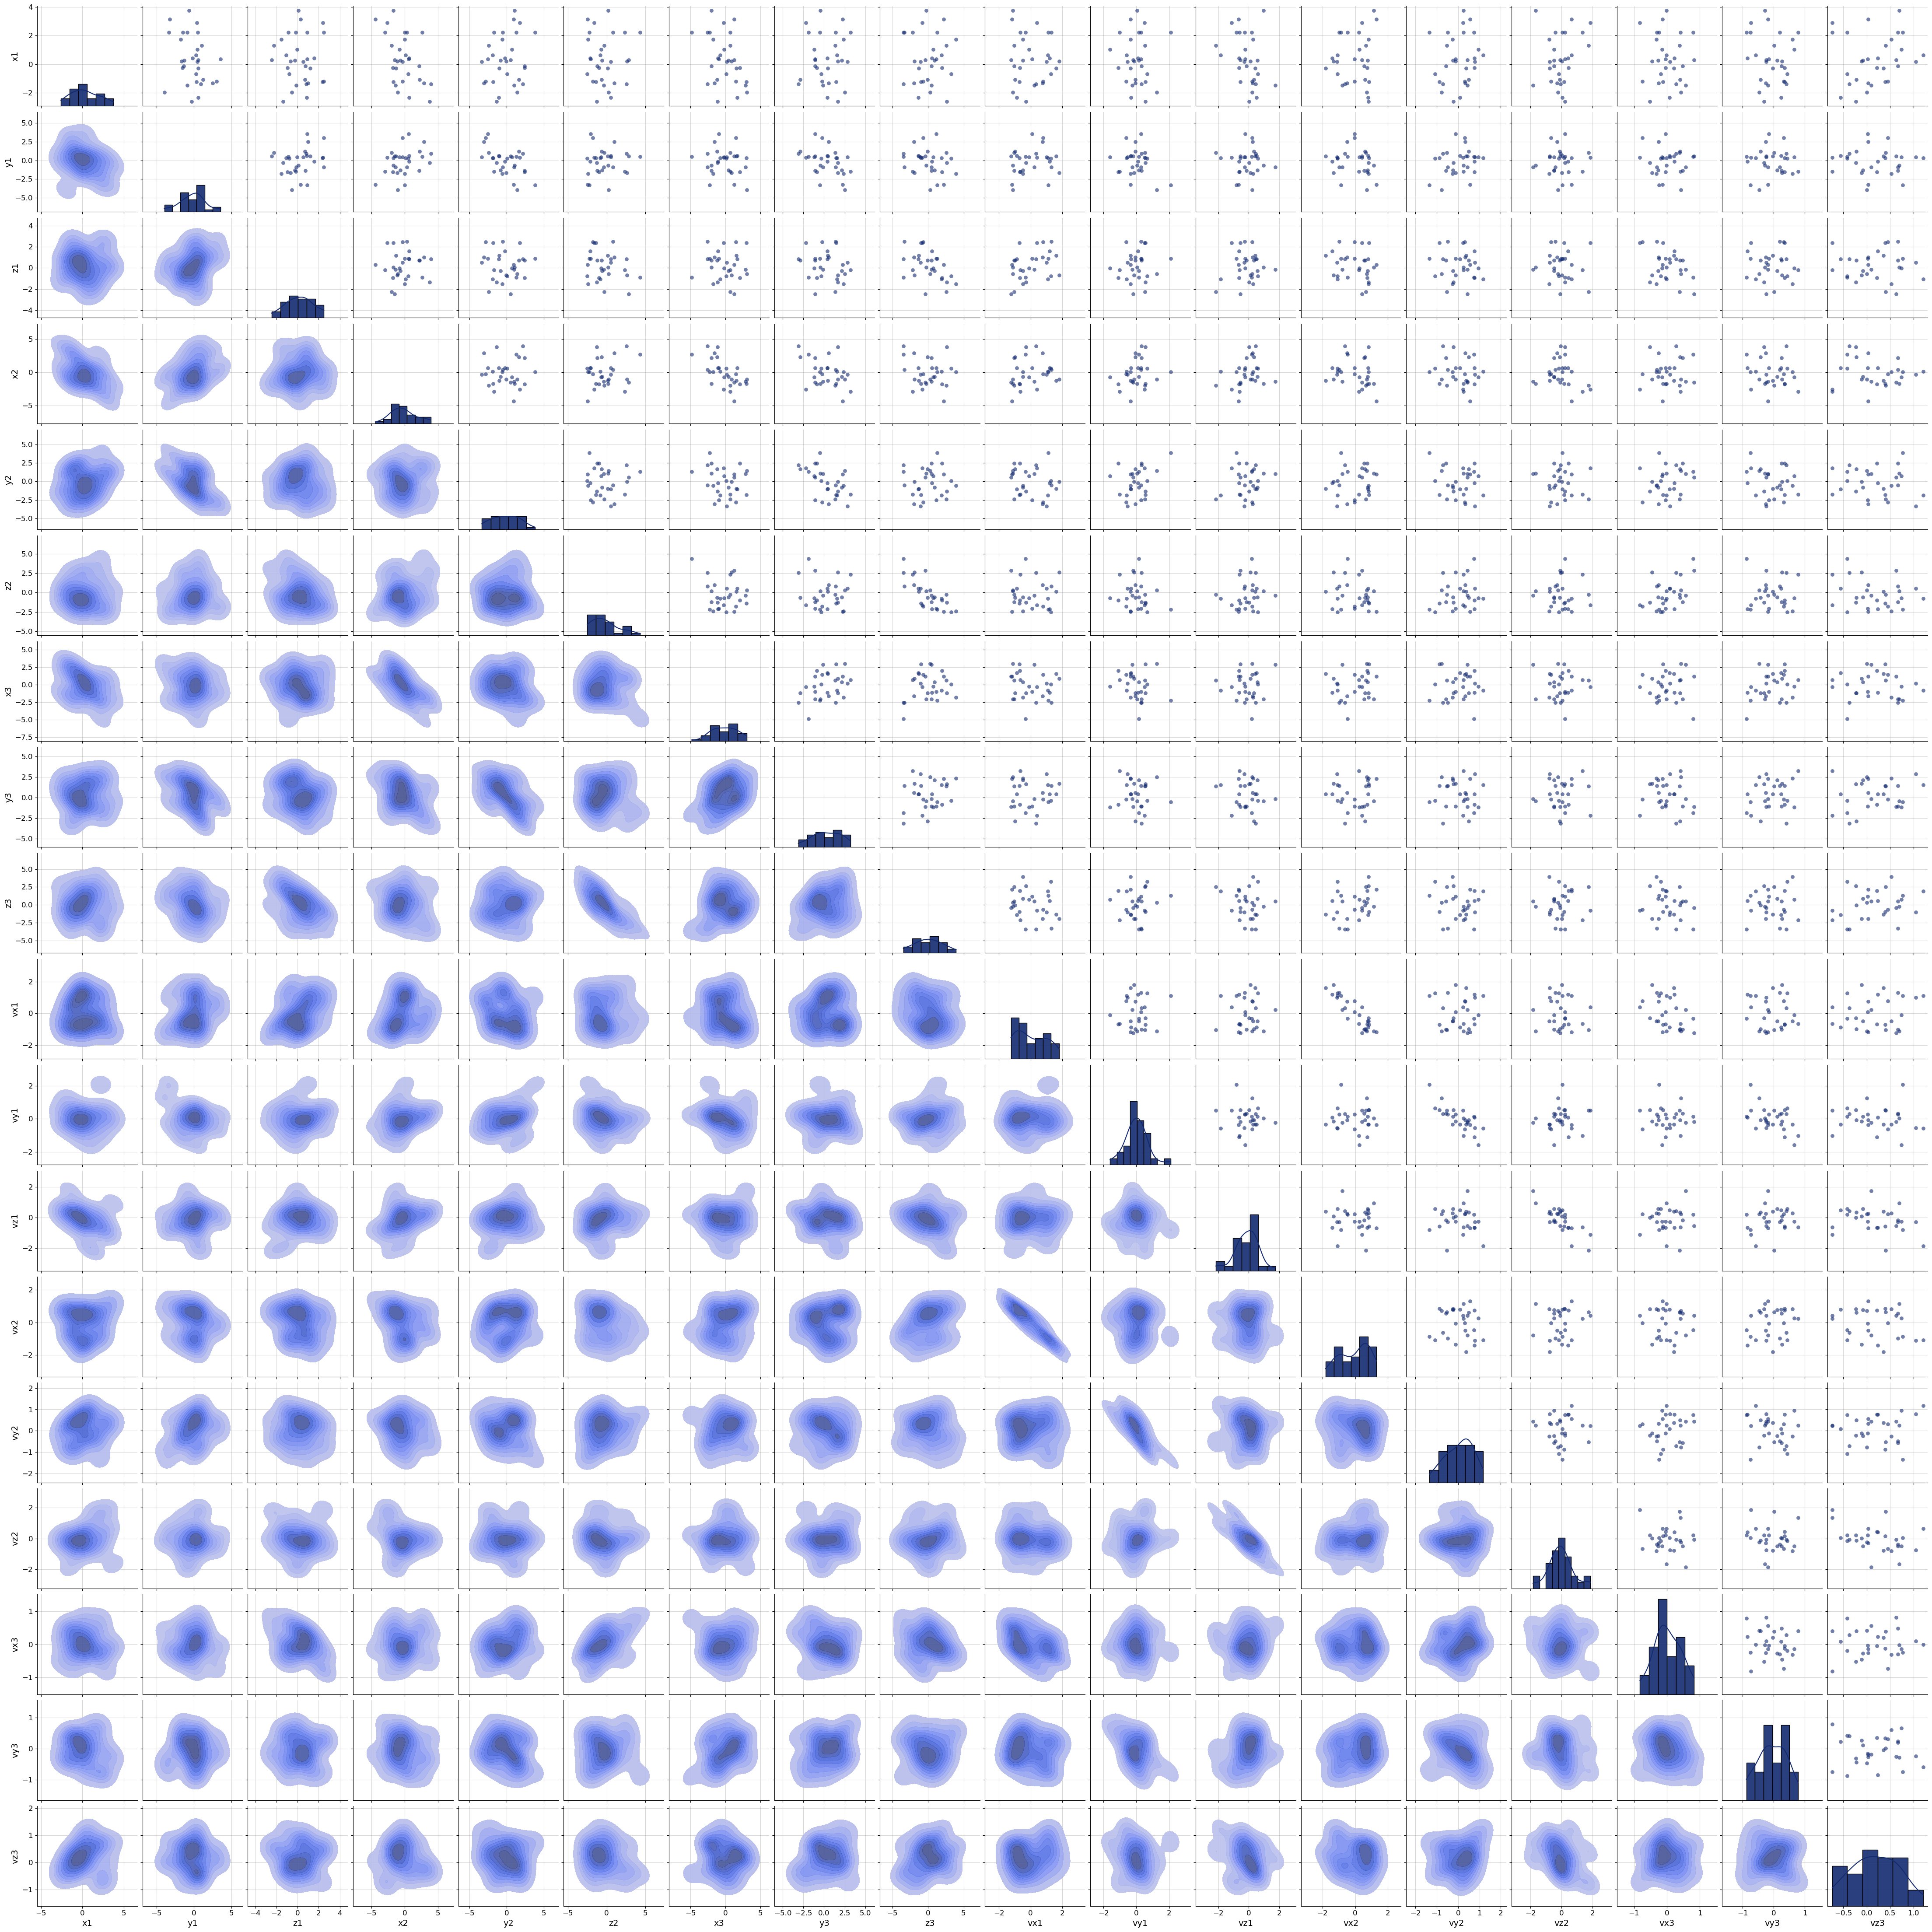

In [8]:
prior_samples = simulator.simulators[0].sample(30)

grid = bf.diagnostics.plots.pairs_samples(
    prior_samples, variable_keys=["x1", "y1", "z1", 
                 "x2","y2", "z2", 
                 "x3","y3", "z3",
                 "vx1", "vy1", "vz1",
                 "vx2", "vy2", "vz2", 
                 "vx3", "vy3", "vz3"]
)

### Adapter

In [9]:
adapter = (
    bf.adapters.Adapter()
    .as_time_series('trjs')
    .convert_dtype("float64", "float32")
    .concatenate(["x1", "y1", "z1", 
                 "x2","y2", "z2", 
                 "x3","y3", "z3",
                 "vx1", "vy1", "vz1",
                 "vx2", "vy2", "vz2", 
                 "vx3", "vy3", "vz3"], into="inference_variables")
    .rename("trjs", "summary_variables")
    
)

In [10]:
adapter

Adapter([0: AsTimeSeries -> 1: ConvertDType -> 2: Concatenate(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'vx1', 'vy1', 'vz1', 'vx2', 'vy2', 'vz2', 'vx3', 'vy3', 'vz3'] -> 'inference_variables') -> 3: Rename('trjs' -> 'summary_variables')])

### Models

In [11]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(18)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
class RegularizedCNNBiGRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv1D(64, 5, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.3)  
        
        self.bigru = layers.Bidirectional(
            layers.GRU(64, return_sequences=False, 
                      dropout=0, recurrent_dropout=0)  # More dropout
        )
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.3)
        
        #  L2 regularization
        self.summary_stats = layers.Dense(18, kernel_regularizer='l2')

    def call(self, time_series, **kwargs):
        training = kwargs.get("stage") == "training"
        x = self.conv(time_series)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)
        
        x = self.bigru(x, training=training)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)
        
        return self.summary_stats(x)

In [13]:
summary_net = RegularizedCNNBiGRU()
inference_net = bf.networks.CouplingFlow()

### Workflow

In [14]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net
)

In [15]:
workflow.summary_network

<RegularizedCNNBiGRU name=regularized_cnn_bi_gru, built=False>

### Simulate train and test data

In [16]:
training_data = workflow.simulate(5000)
validation_data = workflow.simulate(500)

In [17]:
print(f"Shape of training data : {training_data['trjs'].shape}")
print(f"Shape of validation data : {validation_data['trjs'].shape}")

Shape of training data : (5000, 85, 18)
Shape of validation data : (500, 85, 18)


### Training

In [18]:
history = workflow.fit_offline(
    data=training_data, 
    epochs=100, 
    batch_size=64,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - loss: 24.1743 - val_loss: 21.1471
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 15.2525 - val_loss: 9.8776
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 4.2058 - val_loss: -1.0319
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: -3.4641 - val_loss: -4.7747
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: -6.2036 - val_loss: -6.0813
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: -7.6919 - val_loss: -9.0427
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: -9.5840 - val_loss: -10.0225
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -10.3323 - val_loss: -10.0683
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: -11.5394 - val_loss: -9.2742
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: -12.4664 - val_loss: -11.8660
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: -13.4626 - val_loss: -12.5840
Epoch 12/100
79/79 ━━━

### Loss Plot

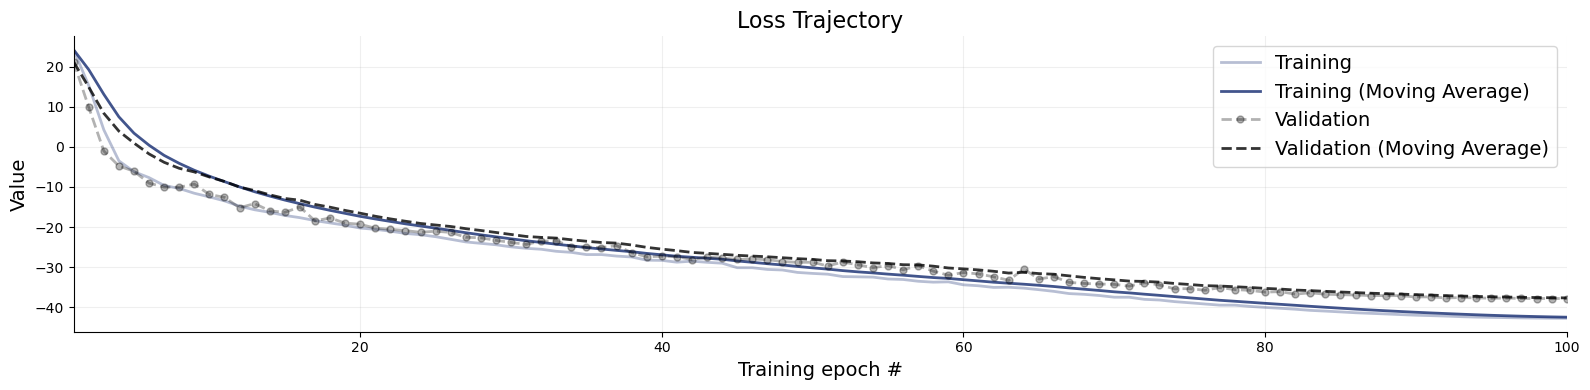

In [28]:
f = bf.diagnostics.plots.loss(history)

### Validation

In [31]:
#number of posterior draws
num_datasets = 300
num_samples = 1000

# Simulate scenarios
test_sims = workflow.simulate(num_datasets)

# Obtain num_samples posterior samples per scenario
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)
parameter_keys = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'vx1', 'vy1', 'vz1', 'vx2', 'vy2', 'vz2', 'vx3', 'vy3', 'vz3']

In [21]:
# # Fix samples: always squeeze last dimension (you know it's (300, 1000, 1))
# for key in samples:
#     if samples[key].ndim == 3 and samples[key].shape[-1] == 1:
#         samples[key] = samples[key].squeeze(-1)

# # Fix test_sims: only squeeze if shape is (300, 1)
# for key in test_sims:
#     if test_sims[key].ndim == 2 and test_sims[key].shape[-1] == 1:
#         test_sims[key] = test_sims[key].squeeze(-1)



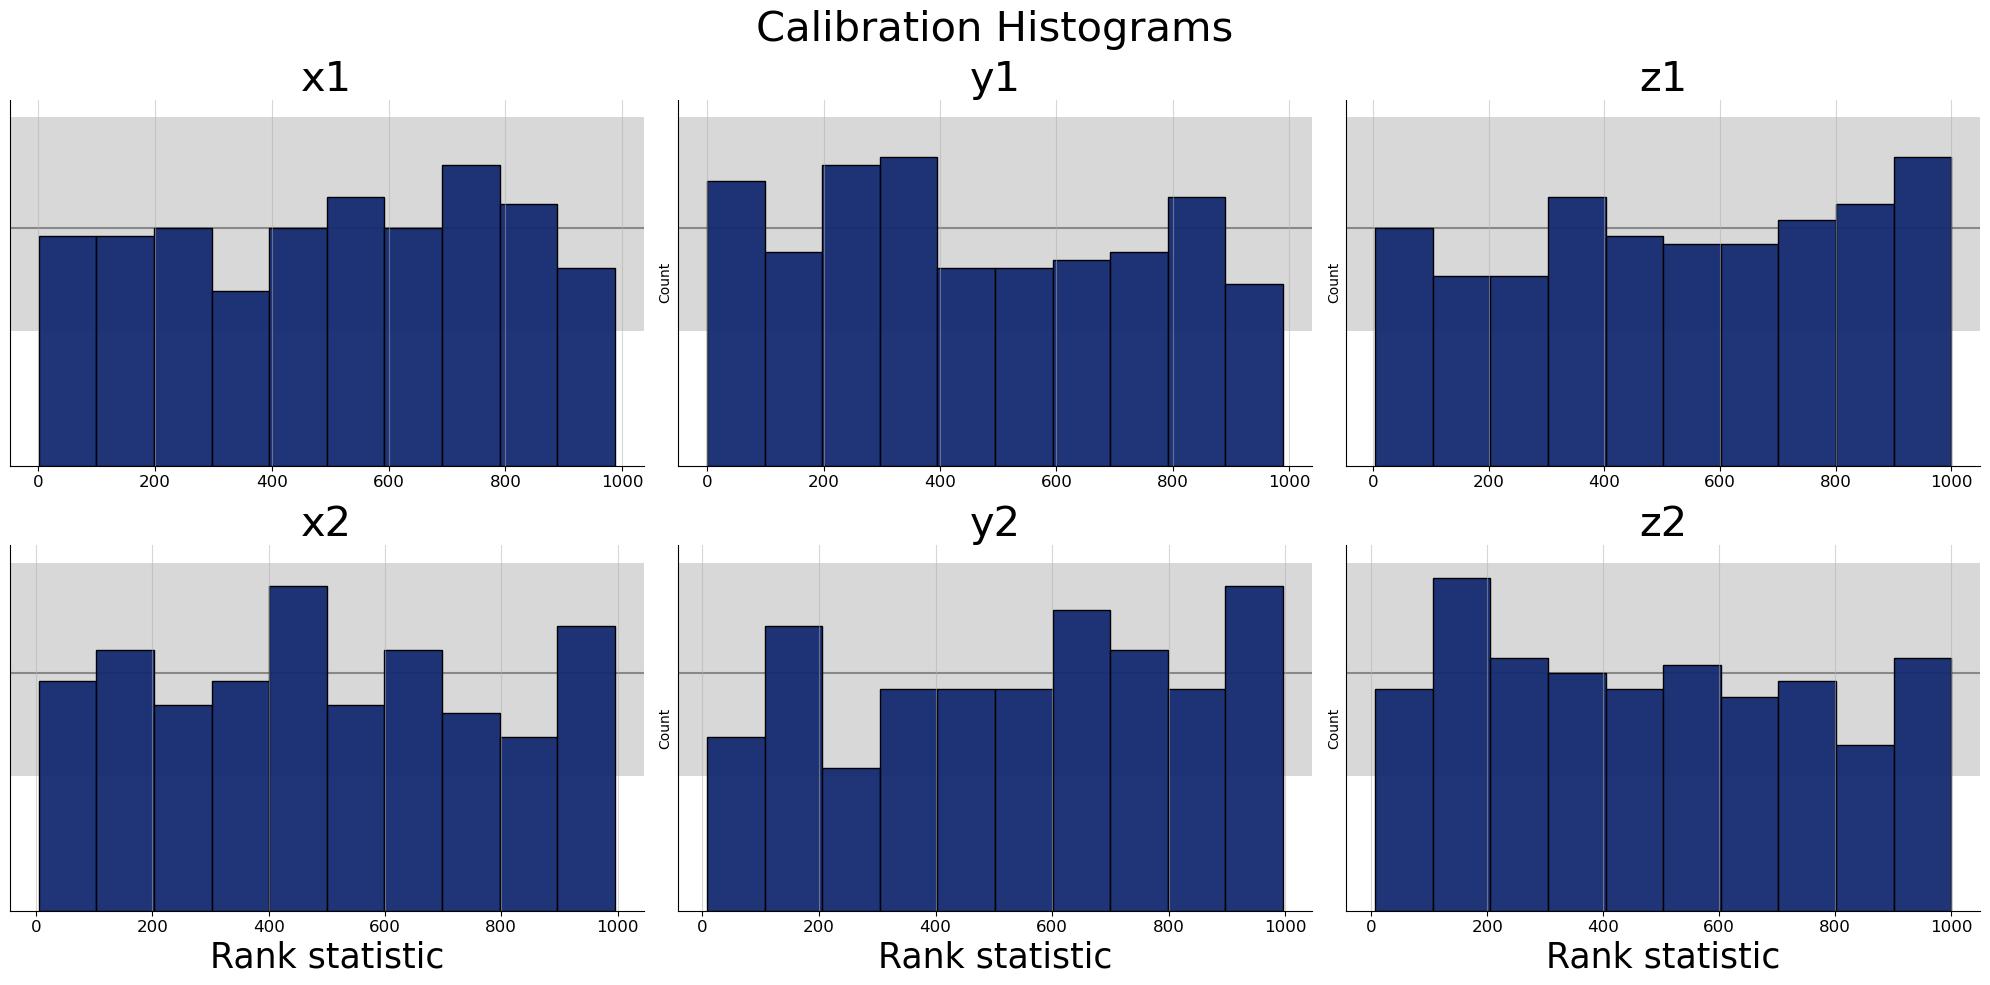

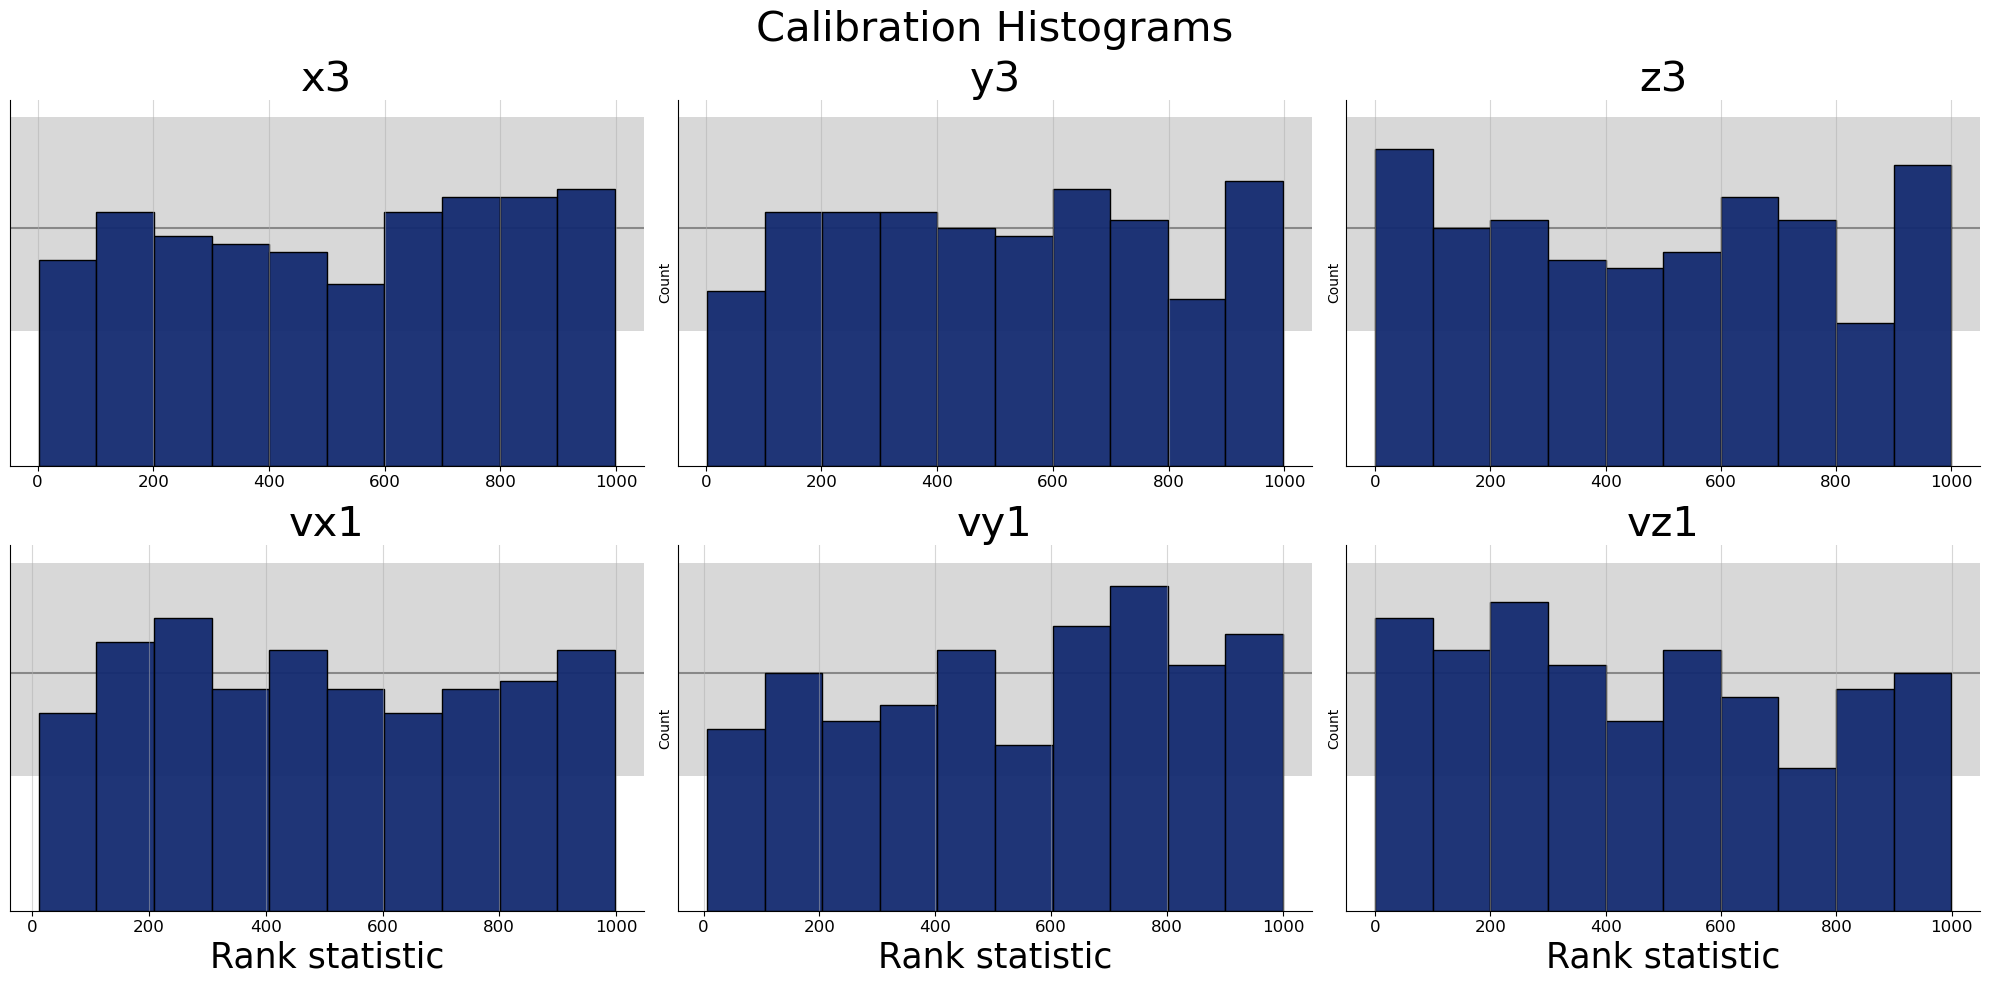

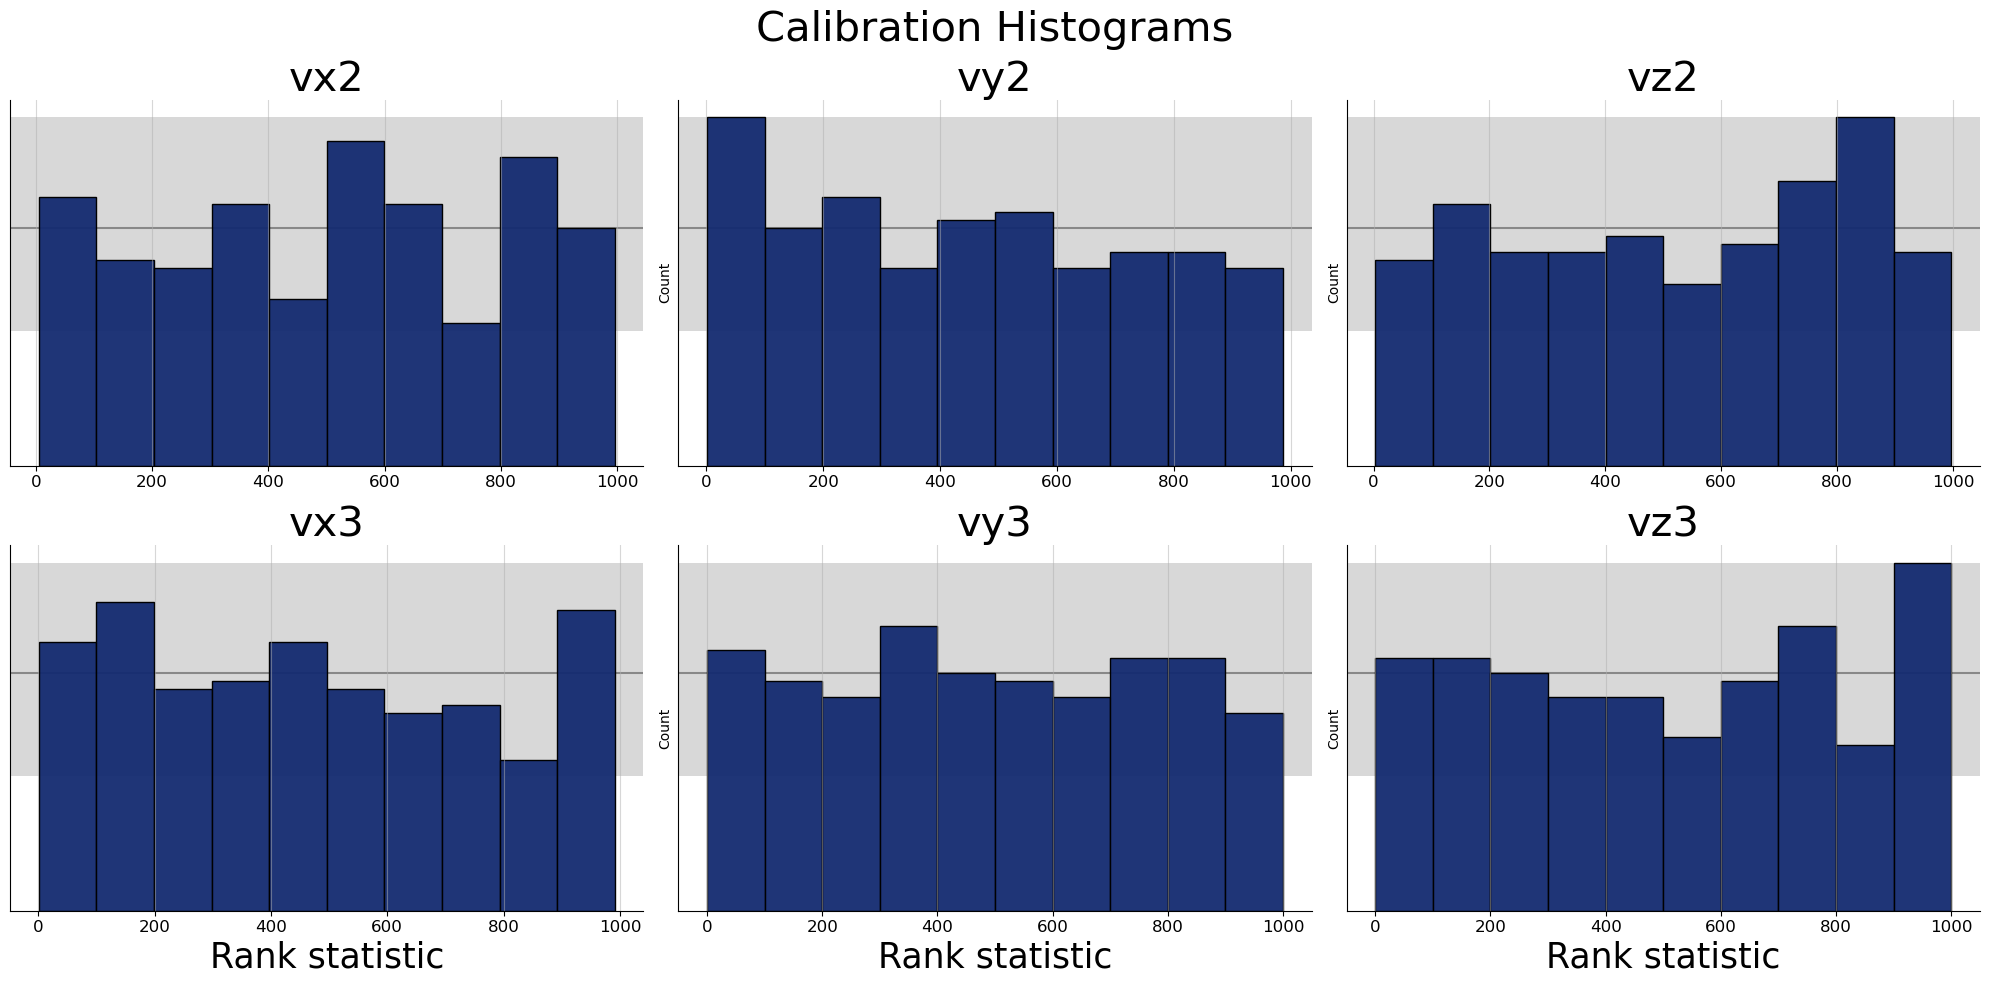

In [42]:
# Split parameters into groups of 6
param_groups = [parameter_keys[i:i+6] for i in range(0, len(parameter_keys), 6)]

# Create separate plots for each group
for i, group in enumerate(param_groups):
    fig = bf.diagnostics.plots.calibration_histogram(
        samples, 
        test_sims,
        variable_keys=group,
        figsize=(20, 10),
        label_fontsize= 25,
        title_fontsize=30,
        num_col=3,  # 3 columns per row
        num_row=2  # 2 rows per figure
    )
    fig.suptitle(f'Calibration Histograms', fontsize=30)
    plt.tight_layout()
    plt.show()

### Calibration ECDF plot.

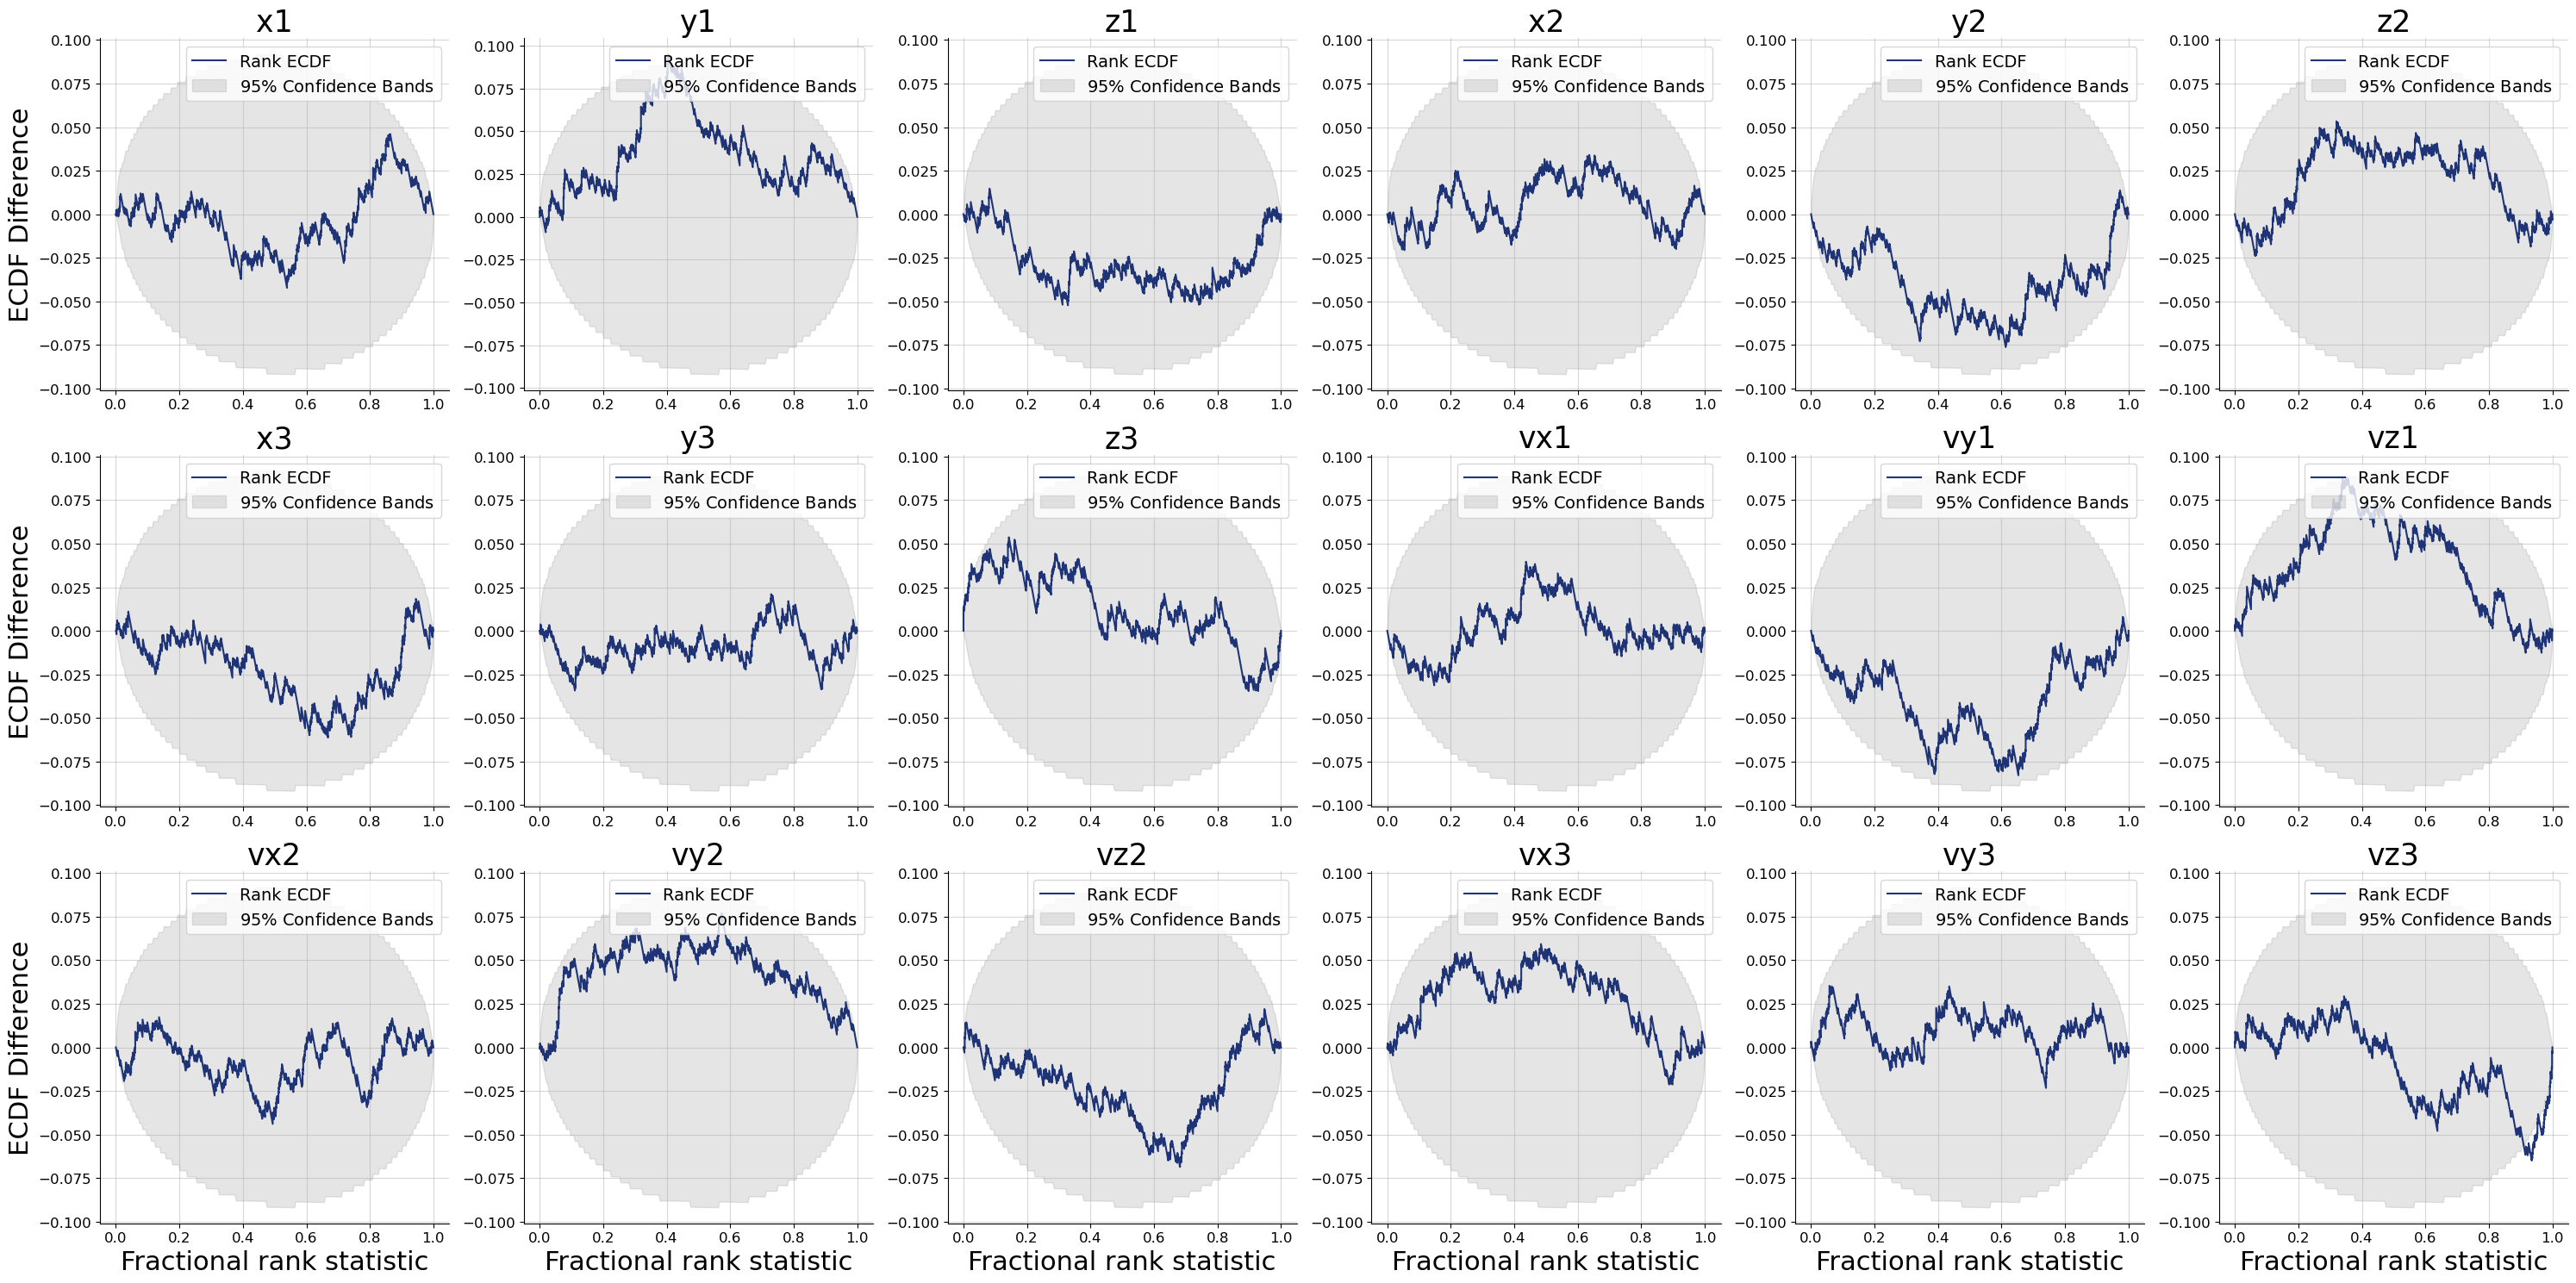

In [33]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True, variable_keys=parameter_keys, title_fontsize=25, label_fontsize=22)

### Recovery Plot

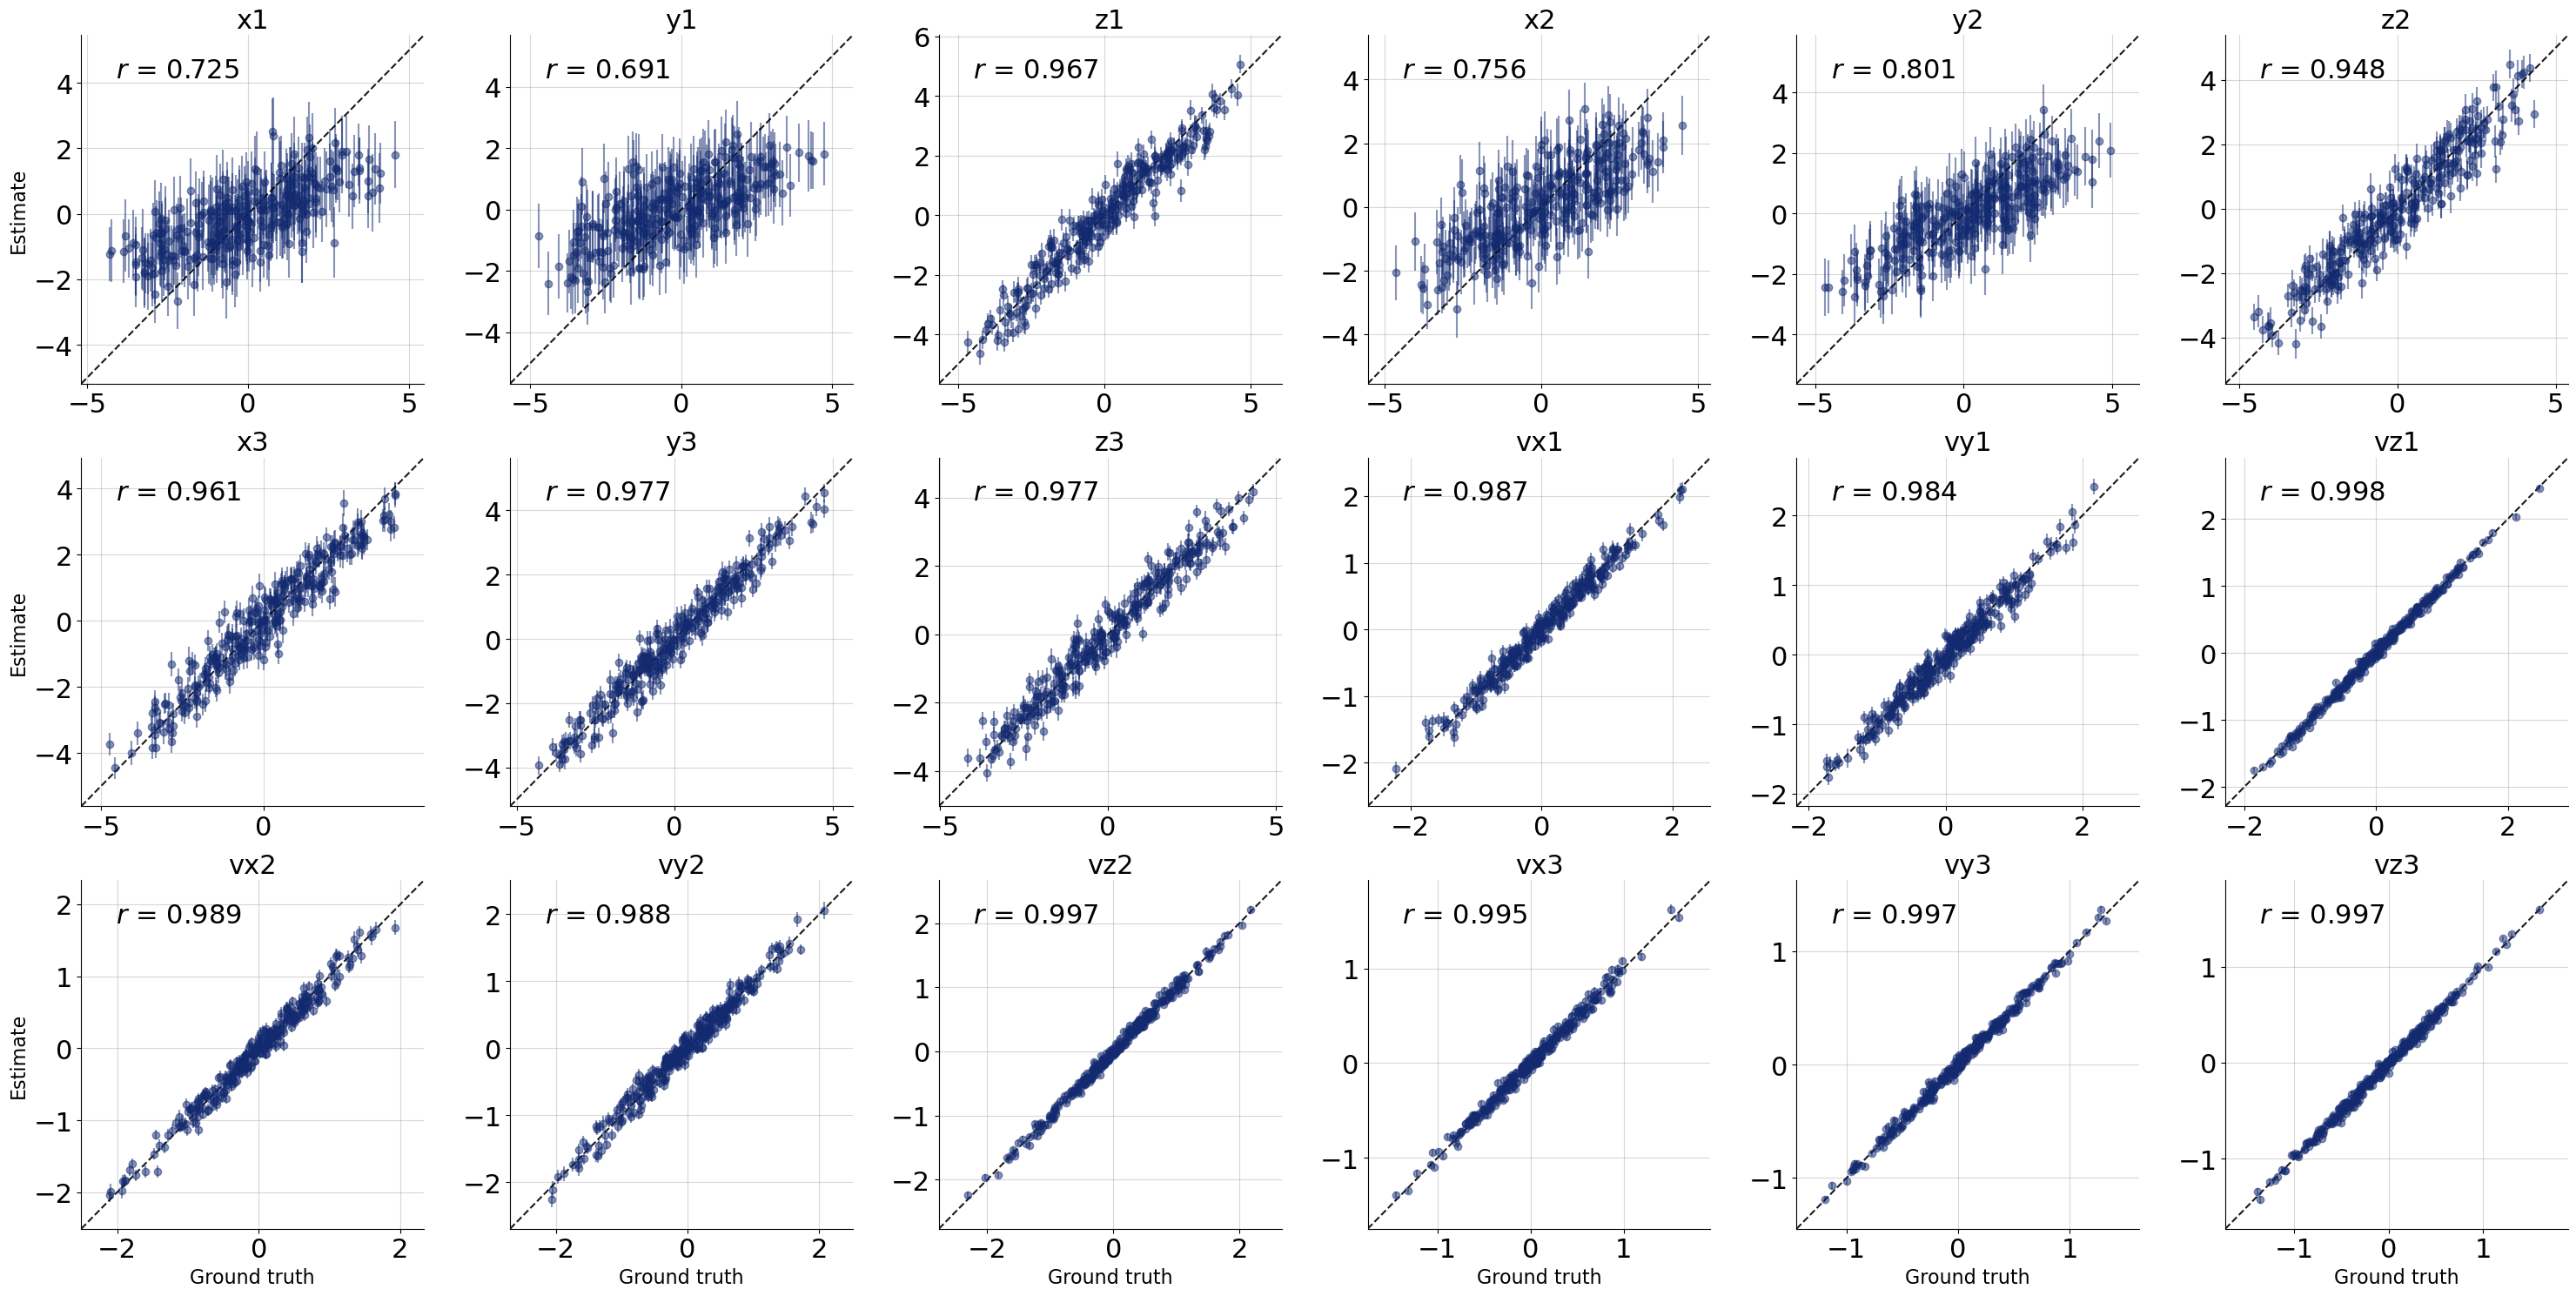

In [34]:
f = bf.diagnostics.plots.recovery(samples, test_sims,variable_keys=parameter_keys, title_fontsize = 22, metric_fontsize=22, tick_fontsize=22)

### Metrics

In [35]:
metrics = workflow.compute_default_diagnostics(test_data=300)
metrics

x1        y1        z1        x2        y2  \
NRMSE                  0.231089  0.230566  0.079007  0.185655  0.190661   
Posterior Contraction  0.418046  0.348993  0.933609  0.586863  0.604203   
Calibration Error      0.010965  0.015614  0.015789  0.009649  0.016228   

                             z2        x3        y3        z3       vx1  \
NRMSE                  0.092724  0.074741  0.062773  0.052992  0.045320   
Posterior Contraction  0.894908  0.938718  0.952475  0.960721  0.970080   
Calibration Error      0.014737  0.009649  0.007632  0.010439  0.012719   

                            vy1       vz1       vx2       vy2       vz2  \
NRMSE                  0.046841  0.017863  0.044178  0.039084  0.021583   
Posterior Contraction  0.968748  0.996068  0.975374  0.977160  0.994082   
Calibration Error      0.023947  0.027105  0.008070  0.030439  0.015965   

                            vx3       vy3       vz3  
NRMSE                  0.024885  0.015266  0.018876  
Posterior Contraction  0.989250  0.995090  0.995590  
Calibration Error      0.013596  0.015263  0.019035

### Default Diagnostics plot.

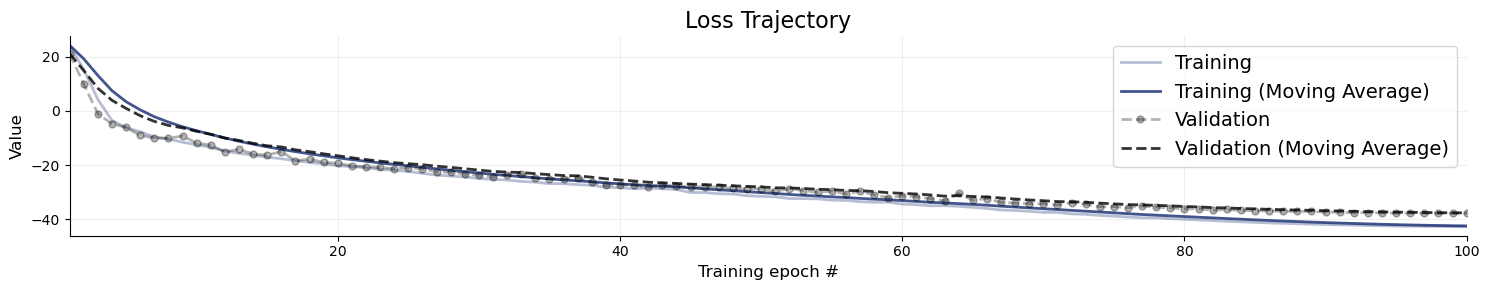

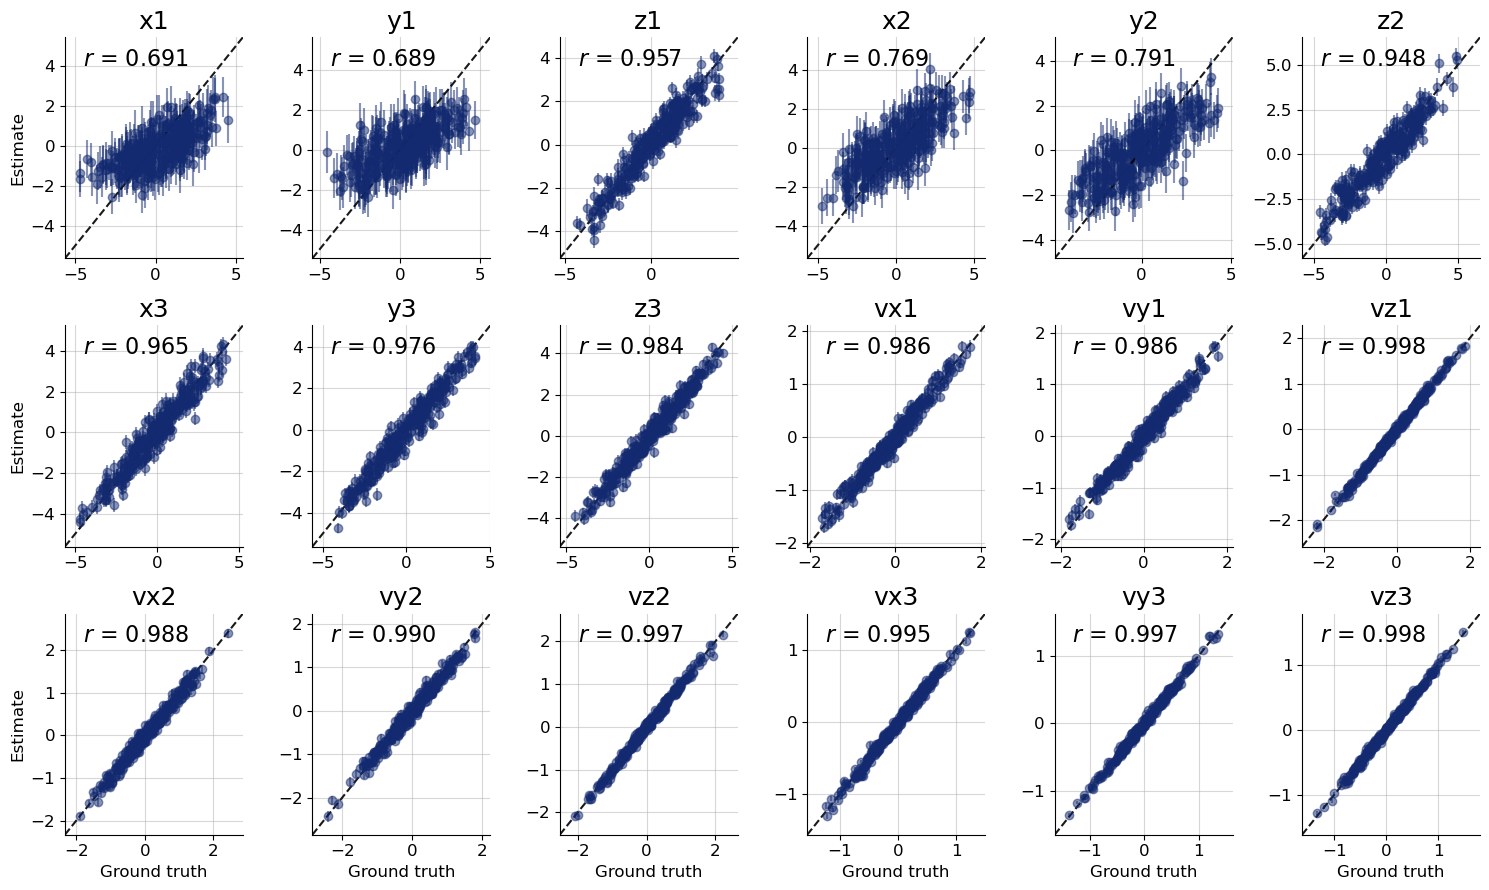

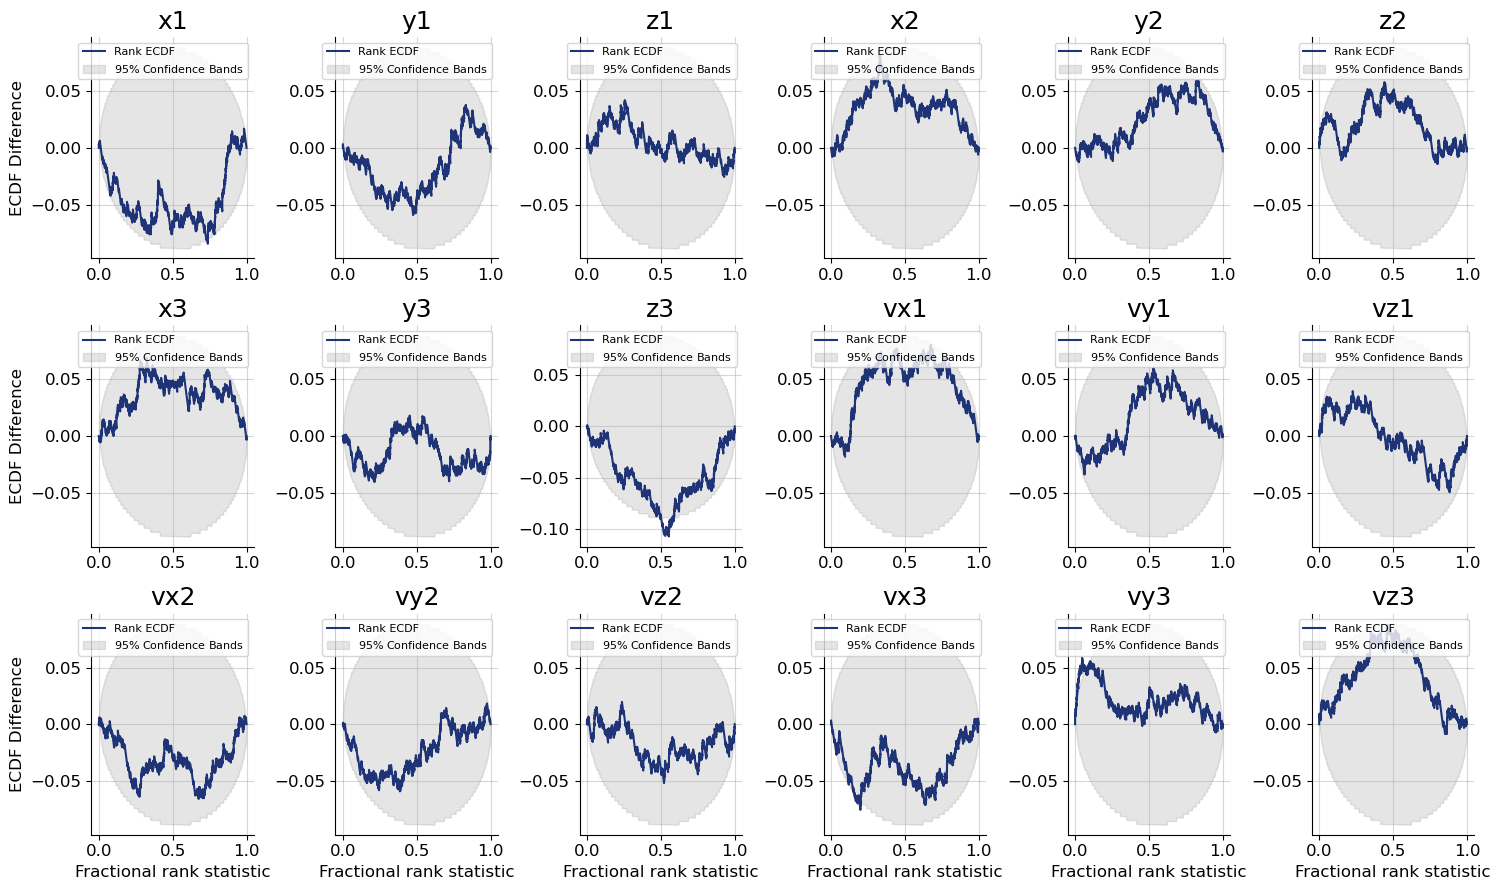

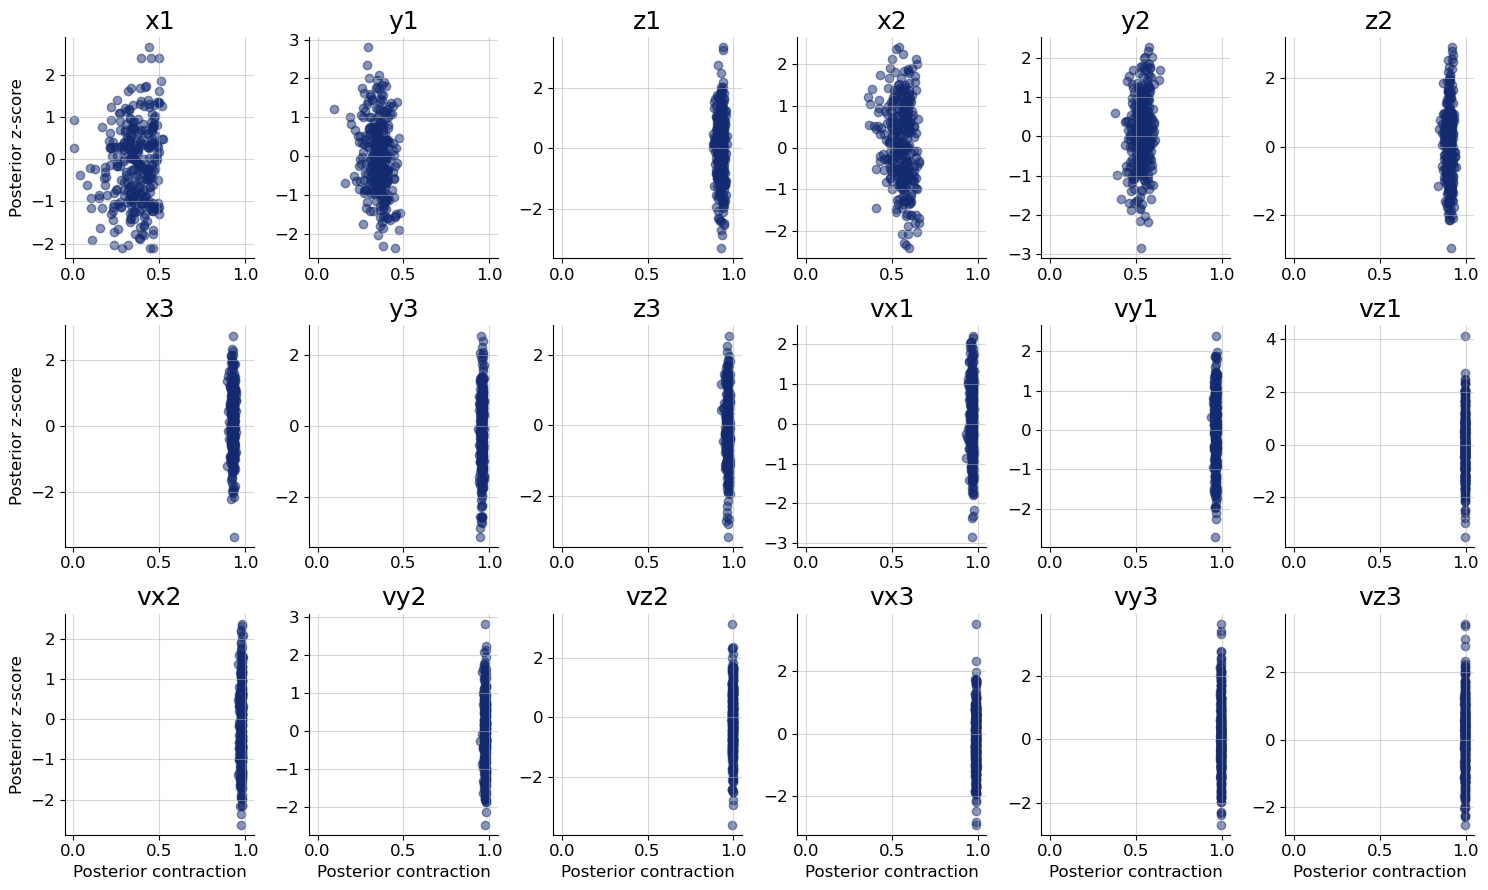

In [26]:
figures = workflow.plot_default_diagnostics(
    test_data=300,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 9), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 9), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 9), "label_fontsize": 12}    
)

### Inference

In [107]:
#number of posterior draws
num_datasets = 300
num_samples = 1000

# Simulate scenarios
test_sims = workflow.simulate(num_datasets)

# Obtain num_samples posterior samples per scenario
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)
parameter_keys = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'vx1', 'vy1', 'vz1', 'vx2', 'vy2', 'vz2', 'vx3', 'vy3', 'vz3']


In [100]:
from matplotlib.patches import Patch
def plot_ppc_grid_full(samples, test_sims, compute_trajectories,
                       dataset_idx=0, num_draws=100,
                       figsize=(15, 12), font_size=14, color="#132a70"):
    """
    PPC plots for all 3 bodies  (x,y,z) positions AND (vx,vy,vz) velocities.

    Args:
        samples: posterior samples dict from workflow.sample
        test_sims: dict from workflow.simulate containing 'trjs'
        compute_trajectories: function that returns dict with key 'trjs'
        dataset_idx: which test dataset to visualize
        num_draws: number of posterior samples to simulate
        figsize: figure size per grid
    """
    import matplotlib.pyplot as plt
    import numpy as np

    plt.rcParams["font.size"] = font_size

    # observed trajectory for one dataset
    obs_trj = test_sims["trjs"][dataset_idx]   # shape (T, 18)

    # parameter ordering
    param_keys = ['x1','y1','z1','x2','y2','z2','x3','y3','z3',
                  'vx1','vy1','vz1','vx2','vy2','vz2','vx3','vy3','vz3']
    post_samples = np.stack([samples[k][dataset_idx,:,0] for k in param_keys], axis=1)

    idxs = np.random.choice(post_samples.shape[0], size=num_draws, replace=False)

    def _make_grid(start_idx, labels, suptitle):
        fig, axes = plt.subplots(3, 3, figsize=figsize, sharex=True)
        legend_elements = [
            plt.Line2D([0], [0], linestyle='--', marker='o', color='black', label='Observed'),
            plt.Line2D([0], [0], color=color, label='Median Prediction'),
            Patch(facecolor=color, alpha=0.5, label='50% CI'),
            Patch(facecolor=color, alpha=0.3, label='90% CI'),
            Patch(facecolor=color, alpha=0.1, label='95% CI')
        ]

        for b in range(3):        # bodies
            for c in range(3):    # coords in labels
                ax = axes[b, c]
                obs_series = obs_trj[:, b*6 + start_idx + c]

                # simulate posterior predictive
                sims = []
                for j in idxs:
                    pars = post_samples[j]
                    traj = compute_trajectories(*pars)["trjs"]
                    sims.append(traj[:, b*6 + start_idx + c])
                sims = np.array(sims)

                # quantiles
                qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
                qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
                qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)

                # plot
                ax.plot(obs_series, "o--", color="black", alpha=0.8,
                        label="Observed" if (b==0 and c==0) else "")
                ax.plot(np.median(sims, axis=0), color=color,
                        label="Median" if (b==0 and c==0) else "")
                ax.fill_between(range(len(obs_series)), qs_50[0], qs_50[1], color=color, alpha=0.5)
                ax.fill_between(range(len(obs_series)), qs_90[0], qs_90[1], color=color, alpha=0.3)
                ax.fill_between(range(len(obs_series)), qs_95[0], qs_95[1], color=color, alpha=0.1)

                if b == 2:
                    ax.set_xlabel("Time step")
                if c == 0:
                    ax.set_ylabel(f"Body {b+1}")

                ax.set_title(labels[b*3 + c])
                ax.grid(alpha=0.3)

        handles, labels_ = axes[0,0].get_legend_handles_labels()
        fig.legend(handles=legend_elements, loc="lower center", 
                  ncol=5, fontsize=font_size+2, frameon=True,
                  bbox_to_anchor=(0.5, -0.05))
        fig.suptitle(f"{suptitle} - Dataset {dataset_idx}", fontsize=font_size+4)
        plt.tight_layout()
        return fig

    # --- Positions grid ---
    pos_labels = ['x1','y1','z1','x2','y2','z2','x3','y3','z3']
    fig_pos = _make_grid(start_idx=0, labels=pos_labels, suptitle="PPC Positions")

    # --- Velocities grid ---
    vel_labels = ['vx1','vy1','vz1','vx2','vy2','vz2','vx3','vy3','vz3']
    fig_vel = _make_grid(start_idx=3, labels=vel_labels, suptitle="PPC Velocities")

    return fig_pos, fig_vel


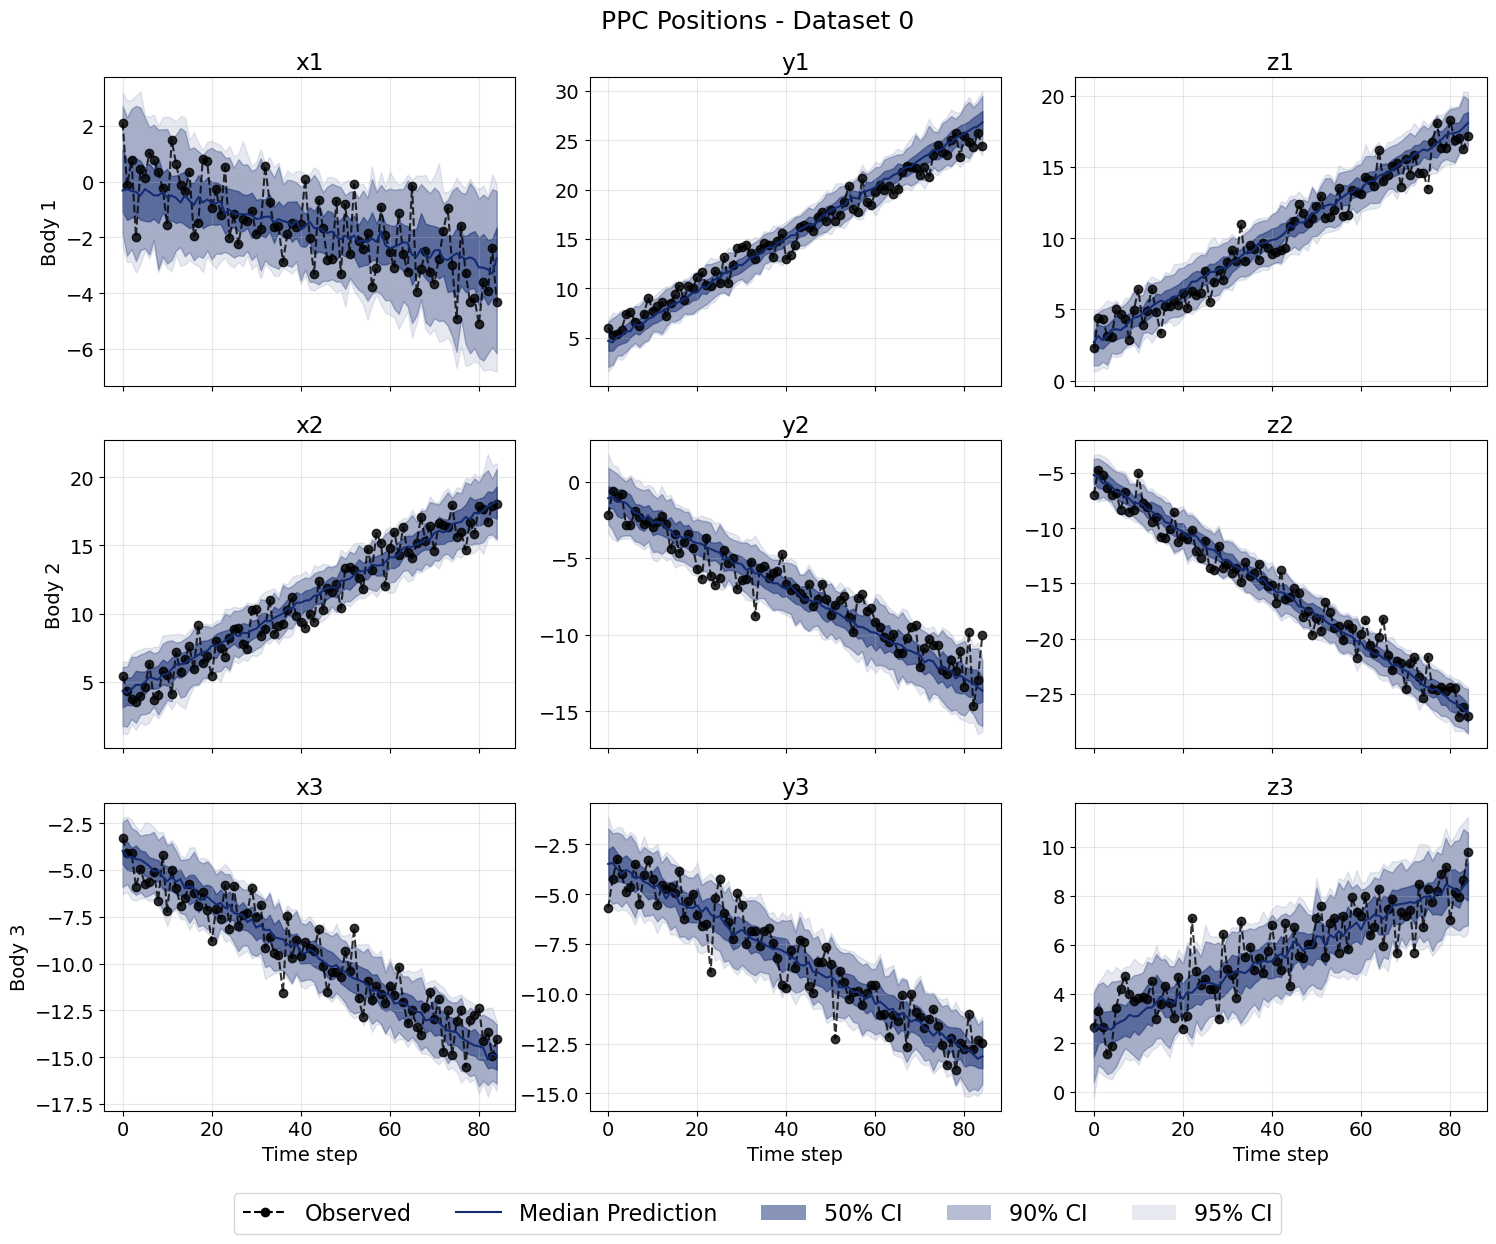

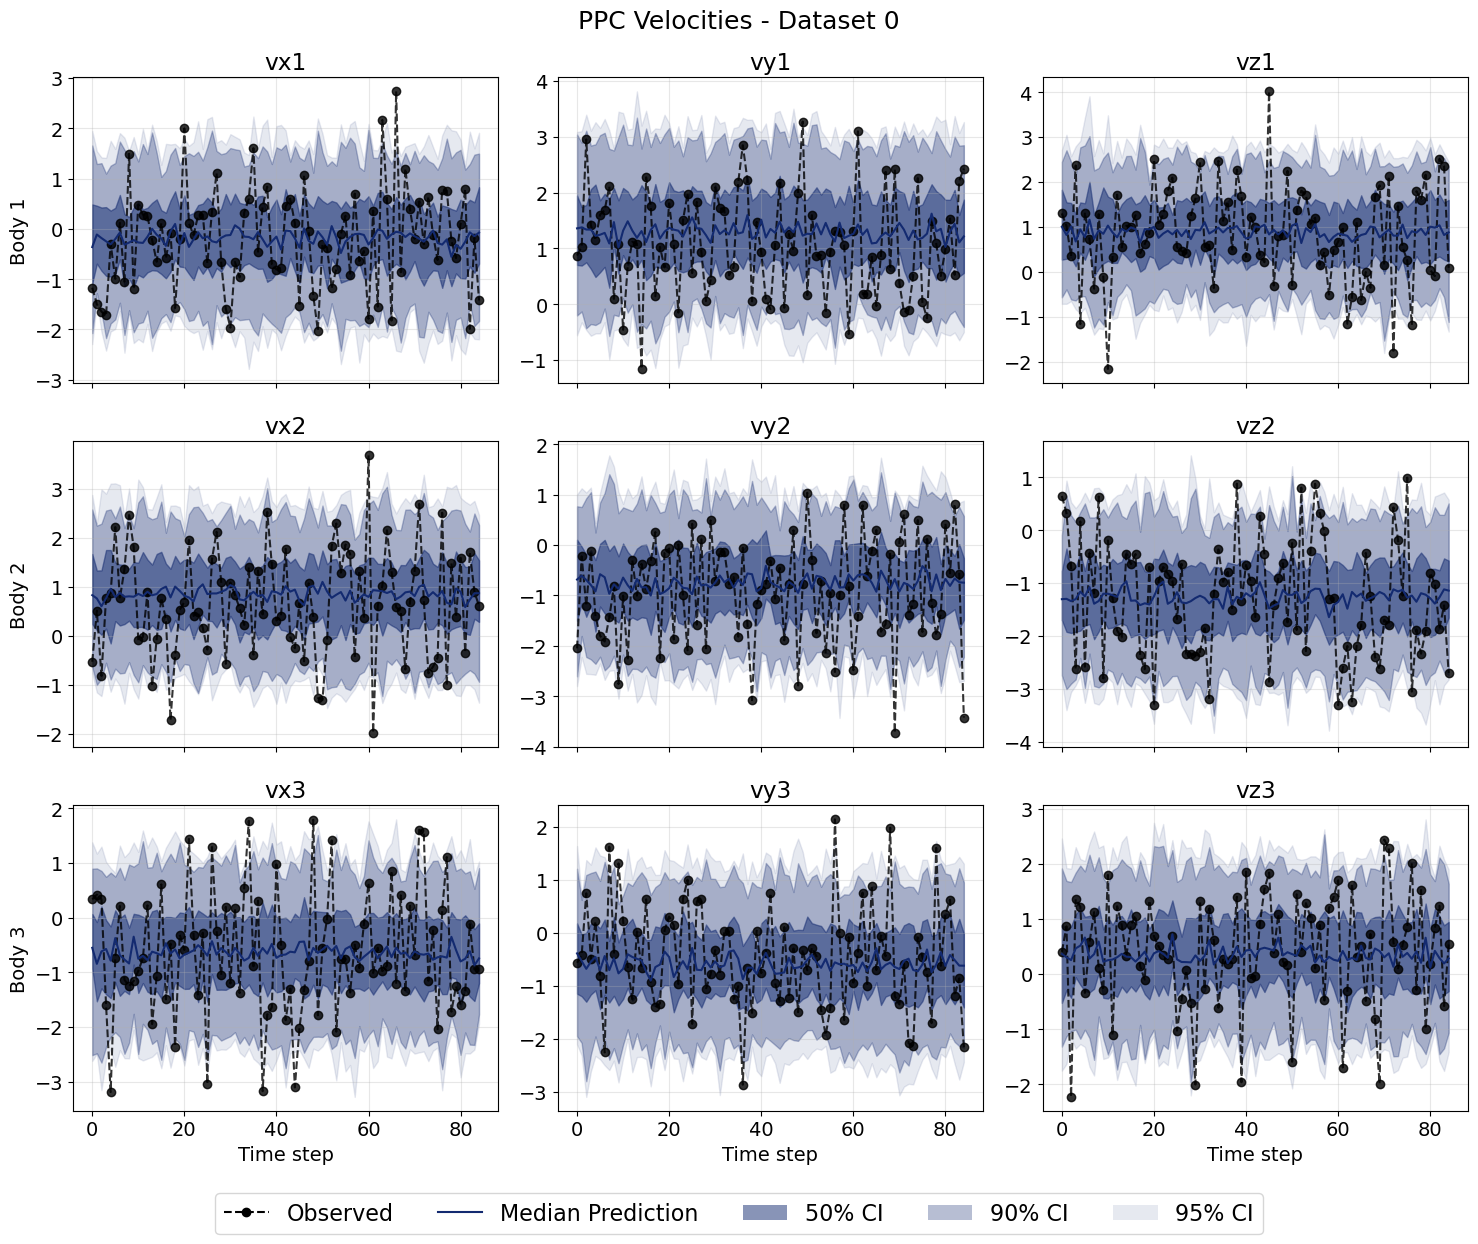

In [108]:
fig_pos, fig_vel = plot_ppc_grid_full(samples, test_sims, compute_trajectories,
                                      dataset_idx=0, num_draws=100)
plt.show()